# Network 05: Adding Generators with Renewable Profiles
# =====================================================
# This notebook demonstrates the complete workflow for adding generators 
# to the clustered European power system network with time-varying capacity factors.
#
# Key steps:
# 1. Load clustered network (from network_04A)
# 2. Process generator data (powerplants.csv)
# 3. Create renewable profiles from weather data (wind speed, solar radiation)
# 4. Add generators with p_max_pu time series
# 5. Validate and save network for optimization

In [35]:
# Setup and imports
from pathlib import Path
import sys
import pypsa
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

def find_repo_root(max_up=6):
    p = Path.cwd().resolve()
    for _ in range(max_up):
        if (p / 'README.md').exists() or (p / '.git').exists():
            return p
        if p.parent == p:
            break
        p = p.parent
    return Path.cwd().resolve()

repo_root = find_repo_root()
src_path = repo_root / 'src/'
if str(src_path) not in sys.path:
    sys.path.insert(1, str(src_path))
print(f"Using src path: {src_path}")
print(f"Repository root: {repo_root}")

# Import our modules
import pypsa_simplified as ps
from pypsa_simplified import network as nw

src_path = repo_root / 'scripts/'
if str(src_path) not in sys.path:
    sys.path.insert(1, str(src_path))

import geometry as geom
import renewable_profiles as rp  # New module for renewable profiles

import network_clust as netclust

# Configuration
JOIN = True
FLOAT_ = True
N_CLUSTERS = 200
STRATEGY = 'gurobi'

Using src path: /Users/jedrek/Documents/Studium Volkswirschaftslehre/3. Semester/European Energy Policy/HA/PyPSA---Simplified-European-Model/PyPSA---Simplified-European-Model/src
Repository root: /Users/jedrek/Documents/Studium Volkswirschaftslehre/3. Semester/European Energy Policy/HA/PyPSA---Simplified-European-Model/PyPSA---Simplified-European-Model


In [ ]:
# Reload module to get latest changes
import importlib
import pypsa_simplified.network as net_module
importlib.reload(net_module)
from pypsa_simplified.network import prepare_generator_data, add_generators_with_profiles

In [37]:
# Analyze generator data structure
print("=== GENERATOR DATA ===")
print(f"Shape: {generators.shape}")
print(f"\nColumns: {list(generators.columns)}")
print(f"\nData types:\n{generators.dtypes}")
print(f"\nFirst 5 rows:")
generators.head()

=== GENERATOR DATA ===
Shape: (29565, 19)

Columns: ['id', 'Name', 'Fueltype', 'Technology', 'Set', 'Country', 'Capacity', 'Efficiency', 'DateIn', 'DateRetrofit', 'DateOut', 'lat', 'lon', 'Duration', 'Volume_Mm3', 'DamHeight_m', 'StorageCapacity_MWh', 'EIC', 'projectID']

Data types:
id                       int64
Name                    object
Fueltype                object
Technology              object
Set                     object
Country                 object
Capacity               float64
Efficiency             float64
DateIn                 float64
DateRetrofit           float64
DateOut                float64
lat                    float64
lon                    float64
Duration               float64
Volume_Mm3             float64
DamHeight_m            float64
StorageCapacity_MWh    float64
EIC                     object
projectID               object
dtype: object

First 5 rows:


id                                       Name   Fueltype     Technology  \
0   0                      Kernkraftwerk Emsland    Nuclear  Steam Turbine   
1   1                                   Brokdorf    Nuclear  Steam Turbine   
2   2                                   Borssele  Hard Coal  Steam Turbine   
3   3  Gemeinschaftskernkraftwerk Neckarwestheim    Nuclear  Steam Turbine   
4   4                                       Isar    Nuclear  Steam Turbine   

  Set      Country  Capacity  Efficiency  DateIn  DateRetrofit  DateOut  \
0  PP      Germany    1336.0        0.33  1988.0        1988.0   2023.0   
1  PP      Germany    1410.0        0.33  1986.0        1986.0   2021.0   
2  PP  Netherlands     485.0         NaN  1973.0           NaN   2034.0   
3  PP      Germany    1310.0        0.33  1976.0        1989.0   2023.0   
4  PP      Germany    1410.0        0.33  1979.0        1988.0   2023.0   

         lat        lon  Duration  Volume_Mm3  DamHeight_m  \
0  52.472897   7.324140       NaN         0.0          0.0   
1  53.850830   9.344720       NaN         0.0          0.0   
2  51.433200   3.716000       NaN         0.0          0.0   
3  49.040019   9.176408       NaN         0.0          0.0   
4  48.605600  12.293150       NaN         0.0          0.0   

   StorageCapacity_MWh                   EIC  \
0                  0.0                 {nan}   
1                  0.0                 {nan}   
2                  0.0  {'49W000000000054X'}   
3                  0.0                 {nan}   
4                  0.0                 {nan}   

                                           projectID  
0  {'MASTR': {'MASTR-SEE944567587799'}, 'ENTSOE':...  
1  {'MASTR': {'MASTR-SEE951462745445'}, 'ENTSOE':...  
2  {'BEYONDCOAL': {'BEYOND-NL-2'}, 'ENTSOE': {'49...  
3  {'MASTR': {'MASTR-SEE985577062814'}, 'ENTSOE':...  
4  {'MASTR': {'MASTR-SEE943690268513'}, 'ENTSOE':...

In [38]:
# Analyze fuel types and technologies
print("=== FUEL TYPES ===")
print(generators['Fueltype'].value_counts())
print("\n=== TECHNOLOGIES ===")
print(generators['Technology'].value_counts().head(20))
print("\n=== COUNTRIES ===")
print(generators['Country'].value_counts().head(15))
print(f"\n=== CAPACITY STATS ===")
print(f"Total capacity: {generators['Capacity'].sum()/1000:.1f} GW")
print(f"By fuel type:")
print(generators.groupby('Fueltype')['Capacity'].sum().sort_values(ascending=False).head(10) / 1000)

=== FUEL TYPES ===
Fueltype
Solar            12091
Wind              9533
Hydro             4124
Natural Gas       1663
Biogas             559
Oil                458
Hard Coal          332
Solid Biomass      233
Lignite            166
Waste              153
Other              121
Nuclear            107
Geothermal          25
Name: count, dtype: int64

=== TECHNOLOGIES ===
Technology
PV                   9633
Onshore              4622
Run-Of-River         2099
Reservoir            1672
Pv                   1485
Steam Turbine        1133
CCGT                  635
Pumped Storage        183
Offshore              132
CSP                    39
Unknown                15
unknown                 4
not found               4
Not Found               2
Combustion Engine       2
Marine                  1
Name: count, dtype: int64

=== COUNTRIES ===
Country
Germany           13543
Spain              2652
France             2572
United Kingdom     1830
Italy              1003
Norway              995
P

In [39]:
weather['Date'] = pd.DatetimeIndex(weather['Date'].values)

In [40]:
# Analyze weather data structure
print("=== WEATHER DATA ===")
print(f"Shape: {weather.shape}")
print(f"\nColumns: {list(weather.columns)[:20]}...")  # First 20 columns
print(f"\nTotal columns: {len(weather.columns)}")
print(f"\nDate range: {weather['Date'].min()} to {weather['Date'].max()}")

# Check structure - looks like columns are NUTS-2 regions
sample_cols = [c for c in weather.columns if c != 'Date'][:10]
print(f"\nSample column names (NUTS-2 regions): {sample_cols}")

# Check for ws (wind speed) and ssrd (solar radiation) columns
ws_cols = [c for c in weather.columns if 'ws' in c.lower() or 'wind' in c.lower()]
solar_cols = [c for c in weather.columns if 'ssrd' in c.lower() or 'solar' in c.lower() or 'rad' in c.lower()]
print(f"\nWind columns found: {len(ws_cols)}")
print(f"Solar columns found: {len(solar_cols)}")

=== WEATHER DATA ===
Shape: (87649, 701)

Columns: ['Date', 'ws_AL01', 'ws_AL02', 'ws_AL03', 'ws_AT11', 'ws_AT12', 'ws_AT13', 'ws_AT21', 'ws_AT22', 'ws_AT31', 'ws_AT32', 'ws_AT33', 'ws_AT34', 'ws_BA11', 'ws_BA20', 'ws_BA21', 'ws_BA22', 'ws_BA23', 'ws_BA24', 'ws_BA25']...

Total columns: 701

Date range: 2015-01-01 00:00:00 to 2024-12-31 00:00:00

Sample column names (NUTS-2 regions): ['ws_AL01', 'ws_AL02', 'ws_AL03', 'ws_AT11', 'ws_AT12', 'ws_AT13', 'ws_AT21', 'ws_AT22', 'ws_AT31', 'ws_AT32']

Wind columns found: 350
Solar columns found: 350


In [41]:
# Parse weather column structure
ws_cols = [c for c in weather.columns if c.startswith('ws_')]
ssrd_cols = [c for c in weather.columns if c.startswith('ssrd_')]

print(f"Wind speed columns: {len(ws_cols)}")
print(f"Solar radiation columns: {len(ssrd_cols)}")

# Extract NUTS-2 region codes
nuts2_regions_ws = [c.replace('ws_', '') for c in ws_cols]
nuts2_regions_ssrd = [c.replace('ssrd_', '') for c in ssrd_cols]

print(f"\nNUTS-2 regions with wind data: {len(nuts2_regions_ws)}")
print(f"Sample: {nuts2_regions_ws[:10]}")

# Check value ranges
print(f"\n=== VALUE RANGES ===")
print(f"Wind speed (m/s): min={weather[ws_cols].min().min():.2f}, max={weather[ws_cols].max().max():.2f}")
print(f"Solar radiation: min={weather[ssrd_cols].min().min():.2f}, max={weather[ssrd_cols].max().max():.2f}")

Wind speed columns: 350
Solar radiation columns: 0

NUTS-2 regions with wind data: 350
Sample: ['AL01', 'AL02', 'AL03', 'AT11', 'AT12', 'AT13', 'AT21', 'AT22', 'AT31', 'AT32']

=== VALUE RANGES ===
Wind speed (m/s): min=0.01, max=27.92
Solar radiation: min=nan, max=nan


In [42]:
# Check for solar radiation columns (might have different prefix)
non_ws_cols = [c for c in weather.columns if not c.startswith('ws_') and c != 'Date']
print(f"Non-wind columns: {len(non_ws_cols)}")
if non_ws_cols:
    print(f"Sample: {non_ws_cols[:10]}")
    
# Check all unique prefixes
prefixes = set()
for c in weather.columns:
    if '_' in c and c != 'Date':
        prefixes.add(c.split('_')[0])
print(f"\nUnique prefixes: {prefixes}")

Non-wind columns: 350
Sample: ['rad_AL01', 'rad_AL02', 'rad_AL03', 'rad_AT11', 'rad_AT12', 'rad_AT13', 'rad_AT21', 'rad_AT22', 'rad_AT31', 'rad_AT32']

Unique prefixes: {'rad', 'ws'}


In [43]:
# Load the clustered network
cluster_path = repo_root / "data" / "networks" / "clustered" / f"C+_sEEN{'_join' if JOIN else ''}{'_f' if FLOAT_ else ''}_cl{N_CLUSTERS}_{STRATEGY}.nc"
print(f"Loading network from: {cluster_path}")

n = pypsa.Network(cluster_path)

# Network summary
print(f"\n{'='*50}")
print("NETWORK SUMMARY")
print(f"{'='*50}")
print(f"Name: {n.name}")
print(f"Buses: {len(n.buses)}")
print(f"Lines: {len(n.lines)}")
print(f"Links: {len(n.links)}")
print(f"Transformers: {len(n.transformers)}")
print(f"Generators: {len(n.generators)}")
print(f"Loads: {len(n.loads)}")
print(f"Snapshots: {len(n.snapshots)}")

Loading network from: /Users/jedrek/Documents/Studium Volkswirschaftslehre/3. Semester/European Energy Policy/HA/PyPSA---Simplified-European-Model/PyPSA---Simplified-European-Model/data/networks/clustered/C+_sEEN_join_f_cl200_gurobi.nc


INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, lines, links, loads, sub_networks



NETWORK SUMMARY
Name: Unnamed Network
Buses: 200
Lines: 237
Links: 28
Transformers: 0
Generators: 0
Loads: 6258
Snapshots: 35064


## 2. Create Renewable Capacity Factor Profiles

Convert weather data (wind speed, solar radiation) to capacity factors using simplified power curves.

**Wind Power Curve:**
- Cut-in: 3 m/s (turbine starts)
- Rated: 12 m/s (full power)  
- Cut-out: 25 m/s (turbine shuts down)

**Solar PV:**
- CF = (Irradiance / 1000 W/m²) × Performance Ratio (0.85)

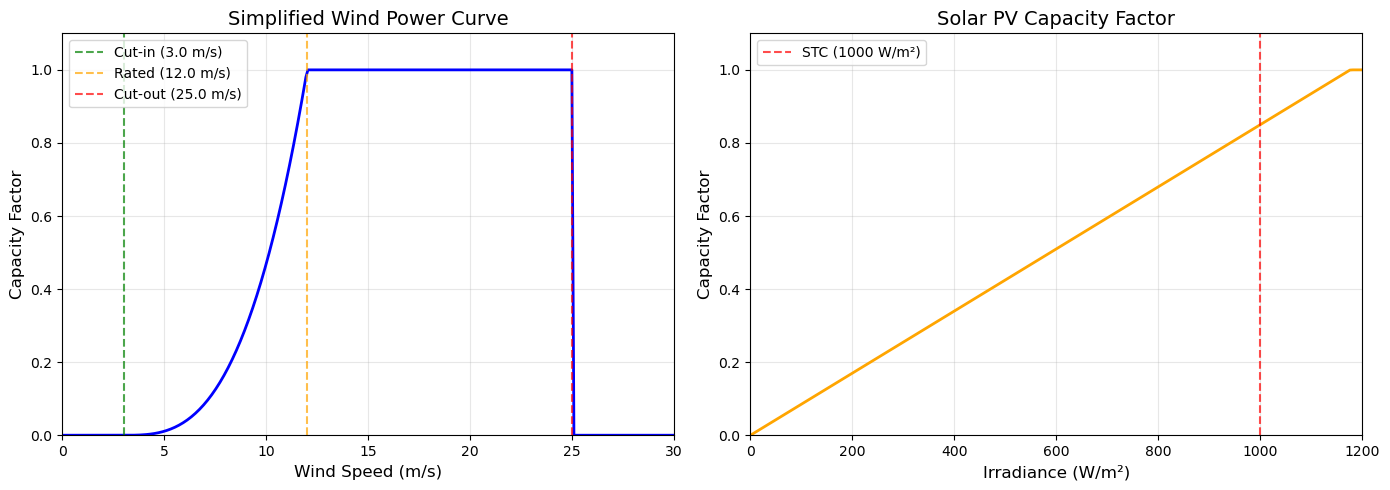

In [44]:
# Visualize the power curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Wind power curve
wind_speeds = np.linspace(0, 30, 300)
wind_cfs = rp.wind_power_curve(wind_speeds)

ax1 = axes[0]
ax1.plot(wind_speeds, wind_cfs, 'b-', linewidth=2)
ax1.axvline(rp.WIND_CUT_IN, color='g', linestyle='--', alpha=0.7, label=f'Cut-in ({rp.WIND_CUT_IN} m/s)')
ax1.axvline(rp.WIND_RATED, color='orange', linestyle='--', alpha=0.7, label=f'Rated ({rp.WIND_RATED} m/s)')
ax1.axvline(rp.WIND_CUT_OUT, color='r', linestyle='--', alpha=0.7, label=f'Cut-out ({rp.WIND_CUT_OUT} m/s)')
ax1.set_xlabel('Wind Speed (m/s)', fontsize=12)
ax1.set_ylabel('Capacity Factor', fontsize=12)
ax1.set_title('Simplified Wind Power Curve', fontsize=14)
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 30)
ax1.set_ylim(0, 1.1)

# Solar capacity factor
ax2 = axes[1]
irradiances = np.linspace(0, 1200, 200)
solar_cfs = rp.solar_capacity_factor(irradiances)
ax2.plot(irradiances, solar_cfs, 'orange', linewidth=2)
ax2.axvline(rp.SOLAR_STC_IRRADIANCE, color='r', linestyle='--', alpha=0.7, label=f'STC ({rp.SOLAR_STC_IRRADIANCE} W/m²)')
ax2.set_xlabel('Irradiance (W/m²)', fontsize=12)
ax2.set_ylabel('Capacity Factor', fontsize=12)
ax2.set_title('Solar PV Capacity Factor', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 1200)
ax2.set_ylim(0, 1.1)

plt.tight_layout()
plt.show()

In [45]:
# Create capacity factor profiles for all NUTS-2 regions
print("Creating renewable capacity factor profiles...")

# Get column lists
ws_cols = [c for c in weather.columns if c.startswith('ws_')]
rad_cols = [c for c in weather.columns if c.startswith('rad_')]

# Parse timestamps
timestamps = pd.to_datetime(weather['Date'])

# Initialize profiles dataframes
wind_profiles_nuts2 = pd.DataFrame(index=timestamps)
solar_profiles_nuts2 = pd.DataFrame(index=timestamps)

# Wind capacity factors per NUTS-2 region
for ws_col in ws_cols:
    nuts2_id = ws_col.replace('ws_', '')
    wind_speed = weather[ws_col].values
    wind_profiles_nuts2[nuts2_id] = rp.wind_power_curve(wind_speed)

# Solar capacity factors per NUTS-2 region  
for rad_col in rad_cols:
    nuts2_id = rad_col.replace('rad_', '')
    irradiance = weather[rad_col].values
    solar_profiles_nuts2[nuts2_id] = rp.solar_capacity_factor(irradiance)

print(f"Wind profiles: {wind_profiles_nuts2.shape}")
print(f"Solar profiles: {solar_profiles_nuts2.shape}")

# Statistics
print(f"\nWind capacity factor: mean={wind_profiles_nuts2.mean().mean():.3f}, max={wind_profiles_nuts2.max().max():.3f}")
print(f"Solar capacity factor: mean={solar_profiles_nuts2.mean().mean():.3f}, max={solar_profiles_nuts2.max().max():.3f}")

Creating renewable capacity factor profiles...


/var/folders/y8/4_9g68pj7k136q2yypgp5ysc0000gn/T/ipykernel_78410/870050918.py:19: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/y8/4_9g68pj7k136q2yypgp5ysc0000gn/T/ipykernel_78410/870050918.py:19: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/y8/4_9g68pj7k136q2yypgp5ysc0000gn/T/ipykernel_78410/870050918.py:19: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.co

Wind profiles: (87649, 350)
Solar profiles: (87649, 350)

Wind capacity factor: mean=0.088, max=1.000
Solar capacity factor: mean=0.127, max=0.876


## 3. Prepare Generator Data

Map generators to network buses and assign carriers, efficiencies, and marginal costs.

In [46]:
# Get countries from network buses
network_countries = n.buses['country'].unique().tolist()
print(f"Countries in network: {len(network_countries)}")
print(f"Countries: {sorted(network_countries)}")

# Prepare generators (filter to network countries, map to buses)
gens_prepared = nw.prepare_generator_data(
    generators_raw=generators,
    network_buses=n.buses,
    countries=network_countries
)

print(f"\nPrepared {len(gens_prepared)} generators")
print(f"\nGenerators by carrier (GW):")
carrier_summary = gens_prepared.groupby('carrier').agg(
    count=('p_nom', 'count'),
    capacity_gw=('p_nom', lambda x: x.sum()/1000)
).round(2)
print(carrier_summary)

INFO:pypsa_simplified.network:Preparing 29565 generators...
INFO:pypsa_simplified.network:Filtered to 28881 generators in 28 countries


Countries in network: 28
Countries: ['AT', 'BE', 'BG', 'CH', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GB', 'GR', 'HR', 'HU', 'IE', 'IT', 'LT', 'LU', 'LV', 'NL', 'NO', 'PL', 'PT', 'RO', 'SE', 'SI', 'SK']


INFO:pypsa_simplified.network:Mapping 28868 generators to 200 buses...
INFO:pypsa_simplified.network:Assigned 28868/28868 generators to buses
INFO:pypsa_simplified.network:Prepared 28868 generators for network addition



Prepared 28868 generators

Generators by carrier (GW):
            count  capacity_gw
carrier                       
biogas        559         3.85
biomass       232        17.92
gas          1645       242.33
geothermal     25         0.81
hard coal     304       148.55
hydro        4057       207.74
lignite       137        60.74
nuclear       102       154.41
oil           458        21.52
other         120         4.45
solar       11578       131.95
waste         153         3.55
wind         9498       286.88


In [47]:
# Load NUTS-2 shapes for spatial assignment
try:
    nuts2_shapes = geom.download_nuts2_shapes()
    print(f"Loaded {len(nuts2_shapes)} NUTS-2 regions")
except Exception as e:
    print(f"Could not load NUTS-2 shapes: {e}")
    nuts2_shapes = None

# Separate renewable and conventional generators
wind_gens = gens_prepared[gens_prepared['carrier'] == 'wind'].copy()
solar_gens = gens_prepared[gens_prepared['carrier'] == 'solar'].copy()
conv_gens = gens_prepared[~gens_prepared['carrier'].isin(['wind', 'solar'])].copy()

print(f"\nGenerator breakdown:")
print(f"  Wind:         {len(wind_gens):5d} ({wind_gens['p_nom'].sum()/1000:.1f} GW)")
print(f"  Solar:        {len(solar_gens):5d} ({solar_gens['p_nom'].sum()/1000:.1f} GW)")
print(f"  Conventional: {len(conv_gens):5d} ({conv_gens['p_nom'].sum()/1000:.1f} GW)")

# Check offshore wind
if 'is_offshore' in wind_gens.columns:
    offshore = wind_gens[wind_gens['is_offshore']]
    onshore = wind_gens[~wind_gens['is_offshore']]
    print(f"\nWind breakdown:")
    print(f"  Onshore:  {len(onshore):5d} ({onshore['p_nom'].sum()/1000:.1f} GW)")
    print(f"  Offshore: {len(offshore):5d} ({offshore['p_nom'].sum()/1000:.1f} GW)")

INFO:geometry:Clipped to continental Europe: 288 NUTS-3 region shapes remain


Loaded 288 NUTS-2 regions

Generator breakdown:
  Wind:          9498 (286.9 GW)
  Solar:        11578 (132.0 GW)
  Conventional:  7792 (865.9 GW)

Wind breakdown:
  Onshore:   9366 (242.0 GW)
  Offshore:   132 (44.9 GW)


In [48]:
# Assign NUTS-2 regions to renewable generators for profile matching
if nuts2_shapes is not None:
    wind_gens = rp.assign_generators_to_nuts2(wind_gens, nuts2_shapes)
    solar_gens = rp.assign_generators_to_nuts2(solar_gens, nuts2_shapes)
    
    print(f"Assigned NUTS-2 regions:")
    print(f"  Wind:  {wind_gens['nuts2_id'].notna().sum():5d}/{len(wind_gens)}")
    print(f"  Solar: {solar_gens['nuts2_id'].notna().sum():5d}/{len(solar_gens)}")
else:
    # Fallback: assign based on country
    print("Using country-level profiles (no NUTS-2 shapes)")
    wind_gens['nuts2_id'] = wind_gens['Country'].str[:2] + '00'
    solar_gens['nuts2_id'] = solar_gens['Country'].str[:2] + '00'

INFO:renewable_profiles:Assigning 9498 generators to NUTS-2 regions...
/Users/jedrek/Documents/Studium Volkswirschaftslehre/3. Semester/European Energy Policy/HA/PyPSA---Simplified-European-Model/PyPSA---Simplified-European-Model/scripts/renewable_profiles.py:338: UserWarning:

Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


/Users/jedrek/Documents/Studium Volkswirschaftslehre/3. Semester/European Energy Policy/HA/PyPSA---Simplified-European-Model/PyPSA---Simplified-European-Model/scripts/renewable_profiles.py:338: UserWarning:

Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


/Users/jedrek/Documents/Studium Volkswirschaftslehre/3. Semester/European Energy Policy/HA/PyPSA---Simplified-European-Model/PyPSA---Simplified-European-Model/scripts/

Assigned NUTS-2 regions:
  Wind:   9498/9498
  Solar: 11578/11578


## 4. Create Generator-Specific Profiles

Create capacity factor profiles for each generator based on their NUTS-2 region.
Offshore wind gets an enhancement factor (1.25x) for stronger sea winds.

In [49]:
# Create generator-specific profiles
print("Creating generator-specific profiles...")

gen_wind_profiles = pd.DataFrame(index=timestamps)
gen_solar_profiles = pd.DataFrame(index=timestamps)

# Wind profiles (with offshore enhancement)
for idx, gen in wind_gens.iterrows():
    gen_name = gen['gen_name']
    nuts2_id = gen.get('nuts2_id')
    is_offshore = gen.get('is_offshore', False)
    
    if nuts2_id and nuts2_id in wind_profiles_nuts2.columns:
        if is_offshore:
            # Apply offshore enhancement: stronger winds at sea
            ws_col = f'ws_{nuts2_id}'
            if ws_col in weather.columns:
                enhanced_ws = weather[ws_col].values * rp.OFFSHORE_WIND_FACTOR
                profile = pd.Series(rp.wind_power_curve(enhanced_ws), index=timestamps)
            else:
                profile = wind_profiles_nuts2[nuts2_id] * 1.1  # Fallback
        else:
            profile = wind_profiles_nuts2[nuts2_id]
        gen_wind_profiles[gen_name] = profile
    else:
        # No profile available - use mean
        gen_wind_profiles[gen_name] = wind_profiles_nuts2.mean(axis=1)

# Solar profiles
for idx, gen in solar_gens.iterrows():
    gen_name = gen['gen_name']
    nuts2_id = gen.get('nuts2_id')
    
    if nuts2_id and nuts2_id in solar_profiles_nuts2.columns:
        gen_solar_profiles[gen_name] = solar_profiles_nuts2[nuts2_id]
    else:
        gen_solar_profiles[gen_name] = solar_profiles_nuts2.mean(axis=1)

print(f"Wind profiles: {gen_wind_profiles.shape}")
print(f"Solar profiles: {gen_solar_profiles.shape}")

# Bundle into dict for add_generators function
profiles = {'wind': gen_wind_profiles, 'solar': gen_solar_profiles}

Creating generator-specific profiles...


/var/folders/y8/4_9g68pj7k136q2yypgp5ysc0000gn/T/ipykernel_78410/2014985777.py:24: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/y8/4_9g68pj7k136q2yypgp5ysc0000gn/T/ipykernel_78410/2014985777.py:24: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/y8/4_9g68pj7k136q2yypgp5ysc0000gn/T/ipykernel_78410/2014985777.py:24: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd

Wind profiles: (87649, 9498)
Solar profiles: (87649, 11578)


## 5. Set Network Snapshots & Add Generators

Define the time period and add all generators to the network.

In [50]:
# Set network snapshots
# For testing: use 1 week. For full analysis: use full year
START_DATE = '2023-01-01'
END_DATE = '2023-01-07 23:00:00'  # 1 week for quick testing
# END_DATE = '2023-12-31 23:00:00'  # Uncomment for full year

snapshots = pd.date_range(start=START_DATE, end=END_DATE, freq='h')
n.set_snapshots(snapshots)

print(f"Network snapshots: {len(n.snapshots)}")
print(f"Period: {n.snapshots[0]} to {n.snapshots[-1]}")

# Clear existing generators (if any)
if len(n.generators) > 0:
    print(f"\nRemoving {len(n.generators)} existing generators...")
    n.remove("Generator", n.generators.index)

Network snapshots: 168
Period: 2023-01-01 00:00:00 to 2023-01-07 23:00:00


In [51]:
# Add renewable generators with profiles (aggregated to bus level for efficiency)
print("Adding renewable generators (aggregated to bus level)...")

# Wind generators
n = nw.add_renewable_generators_aggregated(
    n, wind_gens, profiles, 'wind',
    aggregate_to_bus=True
)

# Solar generators  
n = nw.add_renewable_generators_aggregated(
    n, solar_gens, profiles, 'solar',
    aggregate_to_bus=True
)

print(f"\nRenewable generators added: {len(n.generators)}")

INFO:pypsa_simplified.network:Adding aggregated wind generators...


Adding renewable generators (aggregated to bus level)...


/Users/jedrek/Documents/Studium Volkswirschaftslehre/3. Semester/European Energy Policy/HA/PyPSA---Simplified-European-Model/PyPSA---Simplified-European-Model/src/pypsa_simplified/network.py:1194: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/Users/jedrek/Documents/Studium Volkswirschaftslehre/3. Semester/European Energy Policy/HA/PyPSA---Simplified-European-Model/PyPSA---Simplified-European-Model/src/pypsa_simplified/network.py:1194: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/Users/jedrek/Documents/Studium Volkswirschaftsl


Renewable generators added: 364


In [52]:
# Add conventional generators (no time-varying profiles)
print("Adding conventional generators...")

n = nw.add_generators_with_profiles(
    n, conv_gens, profiles=None,
    name_col='gen_name'
)

print(f"\nTotal generators: {len(n.generators)}")

# Summary
print(f"\n{'='*50}")
print("GENERATOR SUMMARY BY CARRIER")
print(f"{'='*50}")
gen_summary = n.generators.groupby('carrier').agg(
    count=('p_nom', 'count'),
    capacity_gw=('p_nom', lambda x: x.sum()/1000),
    avg_marginal_cost=('marginal_cost', 'mean')
).round(2)
print(gen_summary)

INFO:pypsa_simplified.network:Adding 7792 generators to network...


Adding conventional generators...


INFO:pypsa_simplified.network:Added 7792 generators (0 with time-varying profiles)



Total generators: 8156

GENERATOR SUMMARY BY CARRIER
            count  capacity_gw  avg_marginal_cost
carrier                                          
biogas        559         3.85               50.0
biomass       232        17.92               40.0
gas          1645       242.33               50.0
geothermal     25         0.81                5.0
hard coal     304       148.55               35.0
hydro        4057       207.74                0.0
lignite       137        60.74               25.0
nuclear       102       154.41               10.0
oil           458        21.52               80.0
other         120         4.45               50.0
solar         186       131.95                0.0
waste         153         3.55               20.0
wind          178       286.88                0.0


## 6. Validation & Visualization

In [53]:
# Validation
print("="*50)
print("NETWORK VALIDATION")
print("="*50)
print(f"Buses:       {len(n.buses):6d}")
print(f"Lines:       {len(n.lines):6d}")
print(f"Links:       {len(n.links):6d}")
print(f"Generators:  {len(n.generators):6d}")
print(f"Loads:       {len(n.loads):6d}")
print(f"Snapshots:   {len(n.snapshots):6d}")

# Time series check
print(f"\nTime series:")
print(f"  generators_t.p_max_pu columns: {len(n.generators_t.p_max_pu.columns)}")
print(f"  loads_t.p_set columns: {len(n.loads_t.p_set.columns)}")

# Capacity vs demand check
total_capacity = n.generators['p_nom'].sum()
max_demand = n.loads_t.p_set.sum(axis=1).max() if len(n.loads_t.p_set.columns) > 0 else 0

print(f"\nCapacity check:")
print(f"  Total generation capacity: {total_capacity/1000:.1f} GW")
if max_demand > 0:
    print(f"  Peak demand: {max_demand/1000:.1f} GW")
    print(f"  Capacity margin: {(total_capacity/max_demand - 1)*100:.1f}%")
else:
    print("  No loads defined yet")

NETWORK VALIDATION
Buses:          200
Lines:          237
Links:           28
Generators:    8156
Loads:         6258
Snapshots:      168

Time series:
  generators_t.p_max_pu columns: 364
  loads_t.p_set columns: 5517

Capacity check:
  Total generation capacity: 1284.7 GW
  Peak demand: 422.9 GW
  Capacity margin: 203.8%


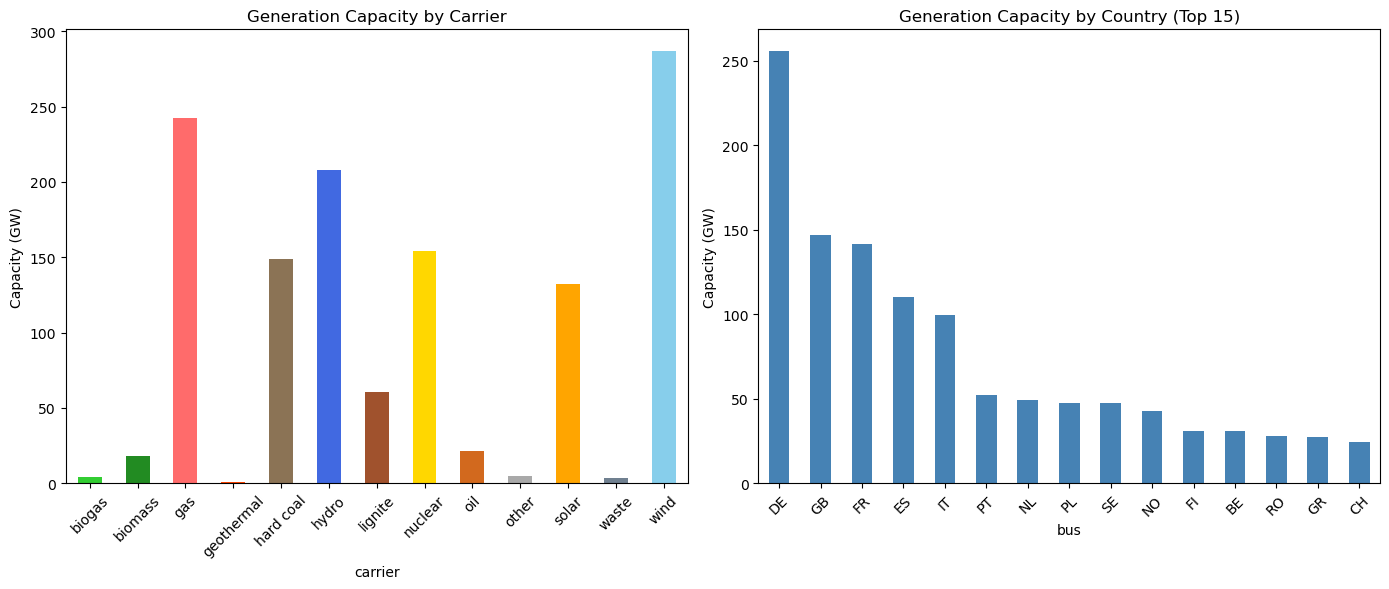

In [54]:
# Visualize capacity by carrier and country
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Capacity by carrier
ax1 = axes[0]
capacity_by_carrier = n.generators.groupby('carrier')['p_nom'].sum() / 1000
colors = [nw.G_CARRIERS.get(c, {}).get('color', '#CCCCCC') for c in capacity_by_carrier.index]
capacity_by_carrier.plot(kind='bar', ax=ax1, color=colors)
ax1.set_ylabel('Capacity (GW)')
ax1.set_title('Generation Capacity by Carrier')
ax1.tick_params(axis='x', rotation=45)

# Capacity by country
ax2 = axes[1]
if 'country' in n.buses.columns:
    gen_countries = n.generators['bus'].map(n.buses['country'])
    capacity_by_country = n.generators.groupby(gen_countries)['p_nom'].sum() / 1000
    capacity_by_country.sort_values(ascending=False).head(15).plot(kind='bar', ax=ax2, color='steelblue')
    ax2.set_ylabel('Capacity (GW)')
    ax2.set_title('Generation Capacity by Country (Top 15)')
    ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

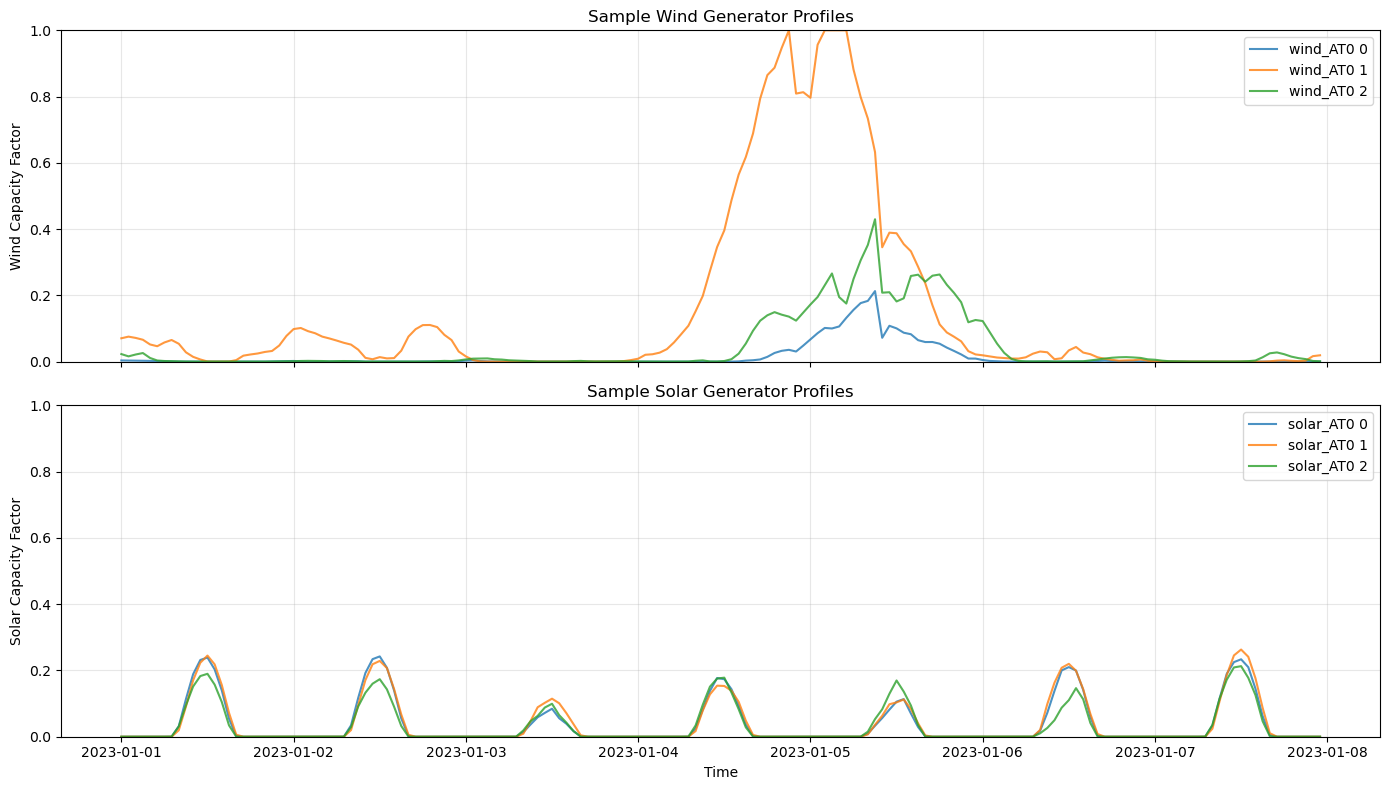

In [55]:
# Visualize sample capacity factor profiles
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Get sample wind and solar generators
wind_gens_in_network = n.generators[n.generators['carrier'] == 'wind'].index[:3]
solar_gens_in_network = n.generators[n.generators['carrier'] == 'solar'].index[:3]

# Wind profiles
ax1 = axes[0]
if len(wind_gens_in_network) > 0 and len(n.generators_t.p_max_pu.columns) > 0:
    for gen in wind_gens_in_network:
        if gen in n.generators_t.p_max_pu.columns:
            ax1.plot(n.snapshots, n.generators_t.p_max_pu[gen], label=gen, alpha=0.8)
ax1.set_ylabel('Wind Capacity Factor')
ax1.set_title('Sample Wind Generator Profiles')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1)

# Solar profiles
ax2 = axes[1]
if len(solar_gens_in_network) > 0 and len(n.generators_t.p_max_pu.columns) > 0:
    for gen in solar_gens_in_network:
        if gen in n.generators_t.p_max_pu.columns:
            ax2.plot(n.snapshots, n.generators_t.p_max_pu[gen], label=gen, alpha=0.8)
ax2.set_xlabel('Time')
ax2.set_ylabel('Solar Capacity Factor')
ax2.set_title('Sample Solar Generator Profiles')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 1)


plt.tight_layout()
plt.show()

## 7. Save Network

In [56]:
# Save network with generators
output_dir = repo_root / 'data' / 'networks' / 'optimize'
output_dir.mkdir(parents=True, exist_ok=True)

output_path = output_dir / f'O+_sEEN_{START_DATE}.nc'
n.export_to_netcdf(output_path)
print(f"Network saved to: {output_path}")

INFO:pypsa.network.io:Exported network 'Unnamed Network' saved to '/Users/jedrek/Documents/Studium Volkswirschaftslehre/3. Semester/European Energy Policy/HA/PyPSA---Simplified-European-Model/PyPSA---Simplified-European-Model/data/networks/optimize/O+_sEEN_2023-01-01.nc contains: links, loads, buses, lines, carriers, sub_networks, generators


Network saved to: /Users/jedrek/Documents/Studium Volkswirschaftslehre/3. Semester/European Energy Policy/HA/PyPSA---Simplified-European-Model/PyPSA---Simplified-European-Model/data/networks/optimize/O+_sEEN_2023-01-01.nc


---
## Next Steps

The network is now ready for optimization. Here are the next steps:

### 1. Add Loads (if not already done)
```python
n = nw.add_loads_from_series(n, join=JOIN, if_float=FLOAT_)
```

### 2. Run Optimization
```python
status, condition = n.optimize(solver_name='highs')
print(f"Status: {status}, Condition: {condition}")
```

### 3. Extension Ideas

#### A. **Fuel Prices & CO2 Pricing**
Update marginal costs based on actual fuel prices:
```python
FUEL_PRICES = {'gas': 35, 'hard coal': 12, 'lignite': 8}  # €/MWhth
CO2_PRICE = 90  # €/tCO2

for carrier, price in FUEL_PRICES.items():
    efficiency = nw.DEFAULT_EFFICIENCIES[carrier]
    co2_intensity = nw.G_CARRIERS[carrier]['co2_emissions']
    marginal_cost = price/efficiency + co2_intensity * CO2_PRICE / efficiency
```

#### B. **Storage Systems**
- Add battery storage with `n.add("StorageUnit", ...)`
- Include pumped hydro from powerplants.csv

#### C. **Investment Optimization**
- Set `p_nom_extendable=True` for capacity expansion
- Add `capital_cost` (€/MW) for new capacity

---

## 7. PyPSA Scenarios Feature

PyPSA provides built-in support for **scenarios** - a powerful feature for analyzing different 
assumptions about the future energy system. Scenarios allow you to systematically vary parameters 
and compare outcomes.

### How Scenarios Work in PyPSA

Scenarios in PyPSA are typically implemented through:

1. **Configuration-based scenarios**: Different config files (like in PyPSA-EUR with Snakemake)
2. **Parameterized scenarios**: Programmatically varying network parameters
3. **Multi-investment periods**: Using `multi_investment_periods` for long-term planning

### Key Methods:

- `n.copy()` - Create scenario copies
- `n.generators.loc[mask, 'parameter'] = value` - Modify parameters
- `n.add('GlobalConstraint', ...)` - Add policy constraints
- `n.optimize(multi_investment_periods=True)` - Multi-period planning

---